# Explicabilidade em Modelos de Visão Computacional

### Objetivos:
- Compreender a importância da explicabilidade em Deep Learning
- Implementar técnicas de visualização: Grad-CAM, Saliency Maps e LIME



## 1. Introdução à Explicabilidade (XAI)

### Por que Explicabilidade é Importante?

A **Inteligência Artificial Explicável (XAI)** é crucial para:
- **Confiança**: Entender como o modelo toma decisões
- **Debugging**: Identificar problemas no modelo
- **Compliance**: Atender regulamentações (LGPD, GDPR)
- **Melhoria**: Otimizar arquiteturas e dados de treino

### Tipos de Explicabilidade:

1. **Global**: Comportamento geral do modelo
2. **Local**: Decisão específica para uma entrada
3. **Post-hoc**: Explicações após o treinamento
4. **Intrinsic**: Modelos inerentemente interpretáveis

### Técnicas que Implementaremos:

| Técnica | Tipo | Granularidade | Complexidade |
|---------|------|---------------|--------------|
| **Grad-CAM** | Post-hoc, Local | Regiões | Média |
| **Saliency Maps** | Post-hoc, Local | Pixels | Baixa |
| **LIME** | Post-hoc, Local | Superpixels | Alta |

---

In [11]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

# Carregar o modelo pré-treinado
model = VGG16(weights='imagenet')

# Obter lista das camadas convolucionais
conv_layers = [layer.name for layer in model.layers if 'conv' in layer.name]

## Grad-CAM (Gradient-weighted Class Activation Mapping)

### Teoria do Grad-CAM

O **Grad-CAM** foi proposto por Selvaraju et al. (2017) e funciona através dos seguintes passos:

1. **Forward Pass**: Obtém ativações da última camada convolucional
2. **Backward Pass**: Calcula gradientes da classe predita em relação às ativações
3. **Pooling**: Faz média global dos gradientes para obter pesos
4. **Weighted Combination**: Combina ativações com pesos
5. **ReLU**: Aplica ReLU para manter apenas influências positivas

### Fórmula Matemática:

$$L_{Grad-CAM}^c = ReLU\left(\sum_k \alpha_k^c A^k\right)$$

Onde:
- $\alpha_k^c = \frac{1}{Z}\sum_i\sum_j\frac{\partial y^c}{\partial A_{ij}^k}$ (importância do canal k)
- $A^k$ são as ativações do canal k
- $y^c$ é o score da classe c

### Implementação:

In [12]:
# Função para carregar e preprocessar a imagem
def load_and_preprocess_img(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_arr = image.img_to_array(img).astype(np.uint8)
    img_exp = np.expand_dims(img_arr, axis=0)
    img_pre = preprocess_input(img_exp)
    return img_pre, img_arr

# Função para calcular o Grad-CAM
def compute_gradcam(model, img_pre, class_idx=None, last_conv_layer='block1_conv1'):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_pre)
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])
        class_channel = predictions[:, class_idx]

    # Gradiente da classe em relação à saída da última camada convolucional
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    # Multiplica cada canal pelo gradiente médio
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # ReLU e normalização
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8  # evitar divisão por zero

    return heatmap, int(class_idx)


# heatmap na imagem original
def overlay_heatmap(heatmap, img_arr, alpha=0.4, colormap=cv2.COLORMAP_JET):
    # Garante que img_arr é uint8 e RGB
    if img_arr.dtype != np.uint8:
        img_arr = np.uint8(img_arr)
    if img_arr.shape[2] == 4:
        img_arr = img_arr[:, :, :3]  # remove alpha se houver

    # Heatmap normalizado para 0-255
    heatmap_resized = cv2.resize(heatmap, (img_arr.shape[1], img_arr.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    
    # Colormap (gera BGR)
    color_heatmap = cv2.applyColorMap(heatmap_resized, colormap)
    # Converte para RGB
    color_heatmap = cv2.cvtColor(color_heatmap, cv2.COLOR_BGR2RGB)
    
    # Faz overlay no RGB
    overlayed = cv2.addWeighted(img_arr, 1 - alpha, color_heatmap, alpha, 0)
    return overlayed


# mostrar resultados
def display_images(heatmap_img, original_img):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(heatmap_img)
    axes[0].set_title("Heatmap sobreposto")
    axes[0].axis('off')
    axes[1].imshow(original_img.astype(np.uint8))
    axes[1].set_title("Imagem original")
    axes[1].axis('off')
    plt.show()


/Users/arnaldoalvesvianajunior/Library/Python/3.9/lib/python/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_115']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
Predição: Afghan_hound (classe 160)


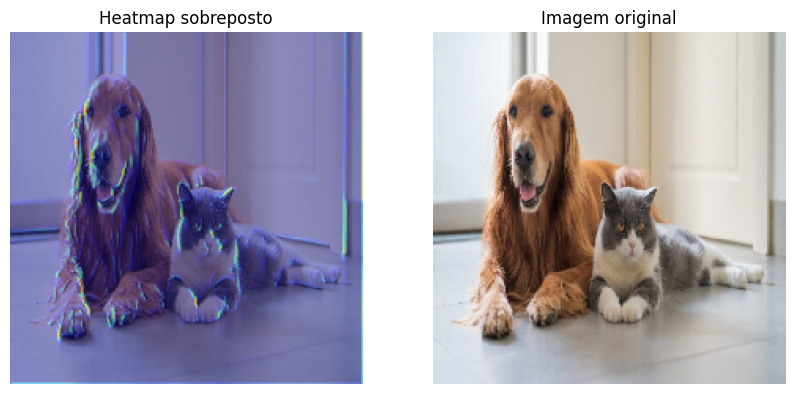

In [13]:

img_path = "lab_images/dogcat.png"

img_pre, img_arr = load_and_preprocess_img(img_path)
heatmap, pred_idx = compute_gradcam(model, img_pre)
pred_class = decode_predictions(model.predict(img_pre), top=1)[0][0][1]

print(f"Predição: {pred_class} (classe {pred_idx})")

# heatmap
heatmap_img = overlay_heatmap(heatmap, img_arr)

# Exibe resultados
display_images(heatmap_img, img_arr)

In [15]:
# ----------- INTERATIVIDADE -------------

import ipywidgets as widgets
from IPython.display import display

img_path = "lab_images/dog.png"

img_pre, img_arr = load_and_preprocess_img(img_path)

def gradcam_interativo(layer_name):
    heatmap, pred_idx = compute_gradcam(model, img_pre, last_conv_layer=layer_name)
    pred_class = decode_predictions(model.predict(img_pre), top=1)[0][0][1]
    print(f"Predição: {pred_class} (classe {pred_idx}) | Camada: {layer_name}")
    heatmap_img = overlay_heatmap(heatmap, img_arr)
    display_images(heatmap_img, img_arr)

layer_dropdown = widgets.Dropdown(
    options=conv_layers,
    value='block5_conv3', # Default: última conv
    description='Camada Conv:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)

widgets.interact(gradcam_interativo, layer_name=layer_dropdown)


interactive(children=(Dropdown(description='Camada Conv:', index=12, layout=Layout(width='400px'), options=('b…

<function __main__.gradcam_interativo(layer_name)>

GradCam++

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
Predição: Afghan_hound (classe 160)


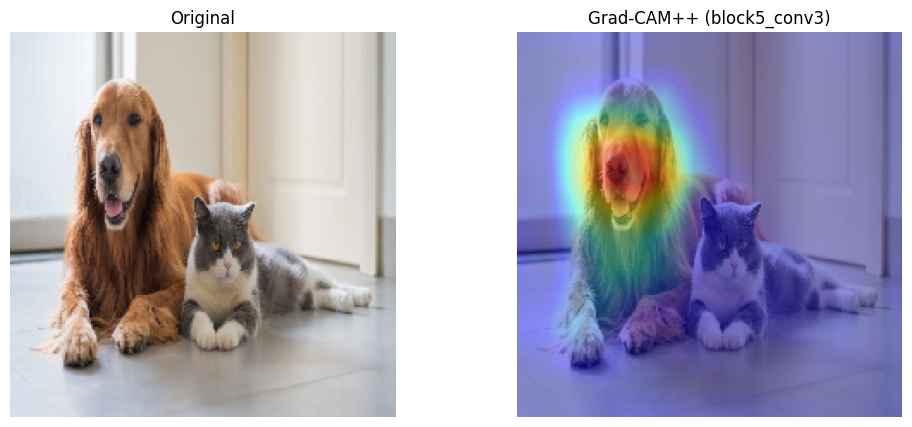

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.scores import CategoricalScore

# Carrega modelo
model = VGG16(weights='imagenet')

# Carrega imagem
img_path = "lab_images/dogcat.png"  # altere se desejar
img = image.load_img(img_path, target_size=(224, 224))
img_arr = image.img_to_array(img)
input_arr = preprocess_input(np.expand_dims(img_arr.copy(), axis=0))

# Predição
preds = model.predict(input_arr)
class_idx = np.argmax(preds)
pred_class = decode_predictions(preds, top=1)[0][0][1]
print(f"Predição: {pred_class} (classe {class_idx})")

# Score function para a classe desejada
score = CategoricalScore([class_idx])

# INTERATIVIDADE: escolha a camada desejada
layer_name = 'block5_conv3'  # ou qualquer camada conv (ex: 'block3_conv3', 'block4_conv3')

gradcam_pp = GradcamPlusPlus(model)
cam = gradcam_pp(score, input_arr, penultimate_layer=layer_name)
cam = np.squeeze(cam)

# Normaliza para visualização
cam_norm = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img_arr.astype(np.uint8))
plt.title('Original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img_arr.astype(np.uint8))
plt.imshow(cam_norm, cmap='jet', alpha=0.4)
plt.title(f'Grad-CAM++ ({layer_name})')
plt.axis('off')
plt.show()


In [6]:
import ipywidgets as widgets
from IPython.display import display

def show_gradcam_plusplus(layer_name):
    gradcam_pp = GradcamPlusPlus(model)
    cam = gradcam_pp(score, input_arr, penultimate_layer=layer_name)
    cam = np.squeeze(cam)
    cam_norm = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    plt.figure(figsize=(10,5))
    plt.imshow(img_arr.astype(np.uint8))
    plt.imshow(cam_norm, cmap='jet', alpha=0.4)
    plt.title(f'Grad-CAM++ ({layer_name})')
    plt.axis('off')
    plt.show()

layer_options = [l.name for l in model.layers if 'conv' in l.name]
widgets.interact(show_gradcam_plusplus, layer_name=widgets.Dropdown(options=layer_options, value='block5_conv3'))


interactive(children=(Dropdown(description='layer_name', index=12, options=('block1_conv1', 'block1_conv2', 'b…

<function __main__.show_gradcam_plusplus(layer_name)>

---

## 4. Técnica 2: Saliency Maps

### Teoria dos Saliency Maps

Os **Saliency Maps** foram introduzidos por Simonyan et al. (2013) e representam uma das técnicas mais simples de explicabilidade:

**Intuição**: Pixels que causam maior mudança na saída quando perturbados são mais importantes.

**Implementação**: Calculamos o gradiente da classe predita em relação aos pixels de entrada:

$$S(x) = \left|\frac{\partial f_c(x)}{\partial x}\right|$$

Onde:
- $f_c(x)$ é o score da classe c para entrada x
- $S(x)$ é o mapa de saliência

### Vantagens:
- ✅ Simplicidade computacional
- ✅ Resolução pixel-level
- ✅ Rápido de computar

### Limitações:
- ❌ Pode ser ruidoso
- ❌ Não considera contexto espacial
- ❌ Sensível a pequenas perturbações

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
Classe predita: Afghan_hound (160)


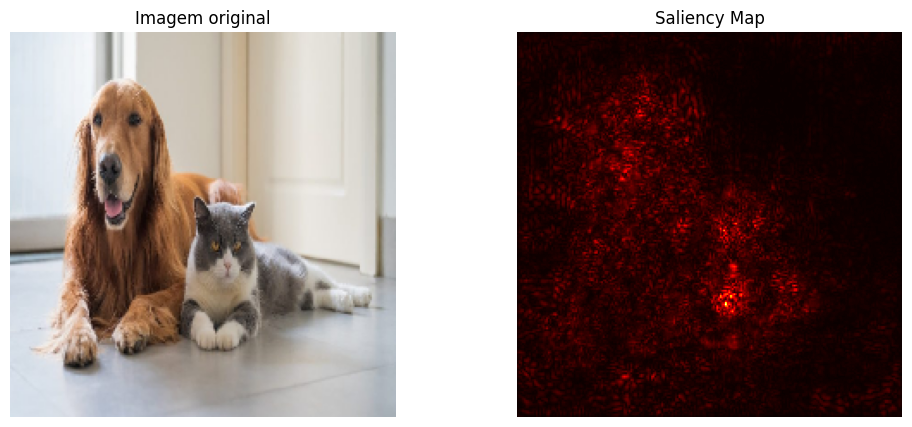

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

# Carregar modelo
model = VGG16(weights='imagenet')

# Carregar imagem
img_path = "lab_images/dogcat.png"
img = image.load_img(img_path, target_size=(224, 224))
img_arr = image.img_to_array(img).astype(np.uint8)
img_pre = preprocess_input(np.expand_dims(img_arr, axis=0))

# Fazer uma predição para obter a classe mais provável
preds = model.predict(img_pre)
class_idx = np.argmax(preds[0])
pred_class = decode_predictions(preds, top=1)[0][0][1]
print(f"Classe predita: {pred_class} ({class_idx})")

# Calcular o Saliency Map
img_tensor = tf.convert_to_tensor(img_pre)
img_tensor = tf.Variable(img_tensor, dtype=float)

with tf.GradientTape() as tape:
    tape.watch(img_tensor)
    predictions = model(img_tensor)
    loss = predictions[:, class_idx]

# Gradiente da saída da classe em relação à imagem de entrada
grads = tape.gradient(loss, img_tensor)[0]

# Saliency map é o valor absoluto do maior gradiente em cada pixel (entre os canais)
saliency = np.max(np.abs(grads), axis=-1)

# Normaliza para 0-1 para visualização
saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)

# Exibe o mapa de saliência
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img_arr.astype(np.uint8))
plt.title('Imagem original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(saliency, cmap='hot')
plt.title('Saliency Map')
plt.axis('off')
plt.show()


---

## 5. Técnica 3: LIME (Local Interpretable Model-agnostic Explanations)

### Teoria do LIME

O **LIME** foi proposto por Ribeiro et al. (2016) e funciona como um método **model-agnostic**:

**Princípio**: Explicar predições através de aproximações locais com modelos interpretáveis.

**Algoritmo**:
1. **Segmentação**: Divide a imagem em superpixels
2. **Perturbação**: Gera amostras mascarando diferentes superpixels  
3. **Predição**: Obtém predições do modelo para cada amostra
4. **Regressão**: Treina modelo linear local para explicar o comportamento
5. **Ranking**: Identifica superpixels mais importantes

### Vantagens:
- ✅ Model-agnostic (funciona com qualquer modelo)
- ✅ Interpretação intuitiva por regiões
- ✅ Estatisticamente fundamentado

### Limitações:
- ❌ Computacionalmente intensivo
- ❌ Dependente da qualidade da segmentação
- ❌ Pode ser instável com poucos samples

/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 894ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 893ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 867ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 897ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

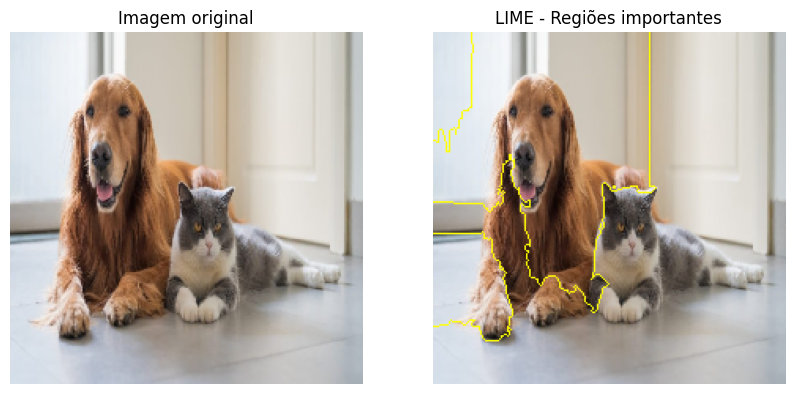

In [8]:
!pip install lime 
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image

# Carregar modelo
model = VGG16(weights='imagenet')

# Função preditora para o LIME (deve retornar probabilidades)
def batch_predict(imgs):
    imgs = np.array([preprocess_input(img) for img in imgs])
    preds = model.predict(imgs)
    return preds

# Carregar imagem
img_path = "lab_images/dogcat.png"
img = image.load_img(img_path, target_size=(224, 224))
img_arr = image.img_to_array(img).astype(np.uint8)

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    img_arr, 
    batch_predict, 
    top_labels=1, 
    hide_color=0, 
    num_samples=1000  # mais = mais robusto, mas mais lento
)

# Pega o label mais provável
label = explanation.top_labels[0]
# Gera o mapa de explicação (superpixels que mais influenciaram)
temp, mask = explanation.get_image_and_mask(label, positive_only=True, num_features=8, hide_rest=False)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_arr.astype(np.uint8))
plt.title("Imagem original")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME - Regiões importantes")
plt.axis('off')
plt.show()


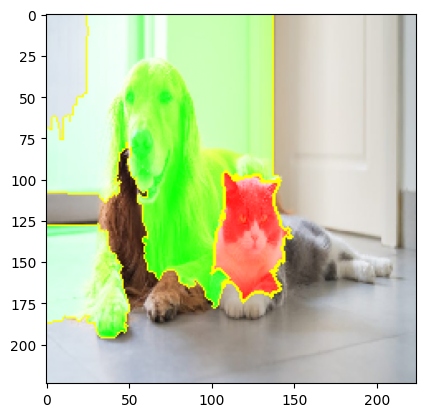

In [9]:

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)